# GPU Check

In [ ]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

# Imports

In [1]:
from search_eval.utils.common_utils import *
from search_eval.eval_no_search_SGLD_ES import Eval_SGLD_ES, SingleImageDataset

from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

import numpy as np
import torch
torch.cuda.empty_cache()

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class DeepImagePrior(nn.Module):
    def __init__(self, in_channels, out_channels, depth):
        super(DeepImagePrior, self).__init__()

        mid_depth = depth // 2

        # Input layer
        self.in_layer = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.convs_enc = nn.ModuleList()
        self.cas_enc = nn.ModuleList()

        # Encoding
        for i in range(mid_depth):
            self.convs_enc.append(nn.Conv2d(2**i * 64, 2**(i+1) * 64, kernel_size=3, padding=1))
            self.cas_enc.append(ChannelAttention(2**(i+1) * 64))

        self.convs_dec = nn.ModuleList()
        self.cas_dec = nn.ModuleList()

        # Decoding
        for i in range(mid_depth, depth - 1):
            self.convs_dec.append(nn.Conv2d(2**(depth-i-1) * 64, 2**(depth-i-2) * 64, kernel_size=3, padding=1))
            self.cas_dec.append(ChannelAttention(2**(depth-i-2) * 64))

        # Output layer
        self.out_layer = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.in_layer(x))
        
        for conv, ca in zip(self.convs_enc, self.cas_enc):
            x = F.relu(conv(x))
            x = ca(x) * x

        for conv, ca in zip(self.convs_dec, self.cas_dec):
            x = F.relu(conv(x))
            x = ca(x) * x

        x = self.out_layer(x)
        return x


model = DeepImagePrior(in_channels=1, out_channels=1, depth=4)


# Execute -- SGLDES

Using cache found in /home/joe/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




----------------------------------
Experiment Configuration:
	Total Iterations: 25000
	Patience: 5000
	Buffer Size: 5000
	Learning Rate: 0.001
	Weight Decay: 5e-07
	Image Resolution: 64
	Plotting every 2000 iterations
----------------------------------


[2023-09-09 07:50:20] WARNING: Validation dataloaders are missing.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model_cls | DeepImagePrior | 751 K 
1 | criteria  | MSELoss        | 0     
---------------------------------------------
751 K     Trainable params
0         Non-trainable params
751 K     Total params
3.007     Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of trainin

Training: 0it [00:00, ?it/s]

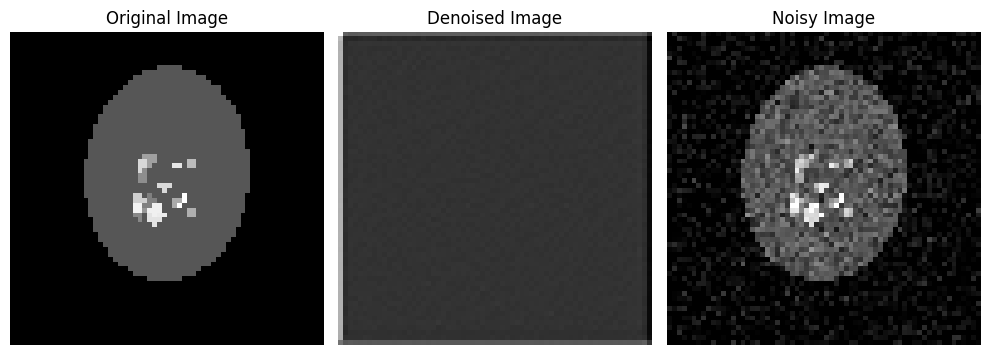

[2023-09-09 07:50:24] Intermediate result: {"iteration": 0, "loss": 0.03645, "psnr_gt": 14.66801}  (Index 0)
[2023-09-09 07:51:10] Intermediate result: {"iteration": 500, "loss": 0.0249, "psnr_gt": 15.77883}  (Index 1)
[2023-09-09 07:51:57] Intermediate result: {"iteration": 1000, "loss": 0.02279, "psnr_gt": 16.16227}  (Index 2)
[2023-09-09 07:52:42] Intermediate result: {"iteration": 1500, "loss": 0.02094, "psnr_gt": 16.40092}  (Index 3)


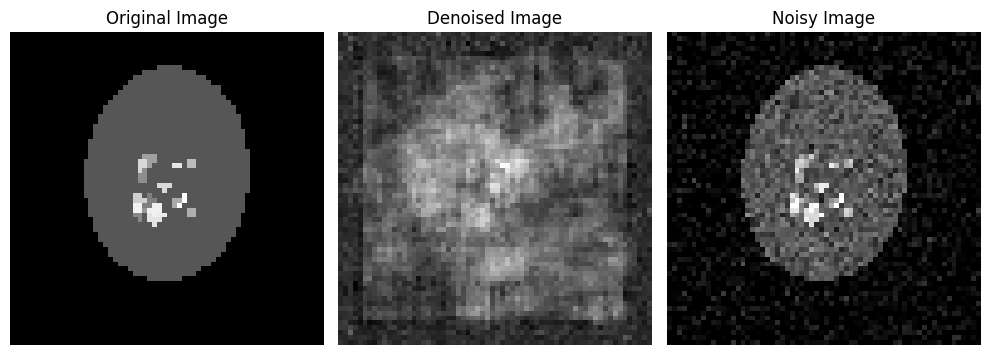

[2023-09-09 07:53:30] Intermediate result: {"iteration": 2000, "loss": 0.01689, "psnr_gt": 17.35021}  (Index 4)
[2023-09-09 07:54:16] Intermediate result: {"iteration": 2500, "loss": 0.0109, "psnr_gt": 19.49045}  (Index 5)
[2023-09-09 07:55:02] Intermediate result: {"iteration": 3000, "loss": 0.00897, "psnr_gt": 20.13647}  (Index 6)
[2023-09-09 07:55:48] Intermediate result: {"iteration": 3500, "loss": 0.00612, "psnr_gt": 21.33722}  (Index 7)


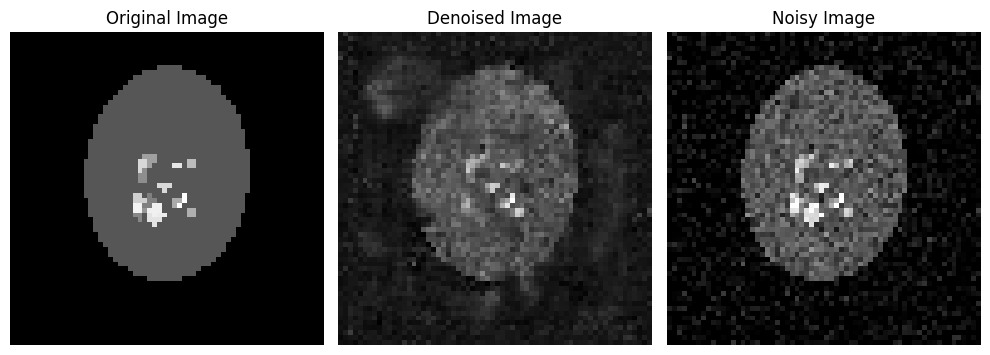

[2023-09-09 07:56:35] Intermediate result: {"iteration": 4000, "loss": 0.00459, "psnr_gt": 21.75205}  (Index 8)
[2023-09-09 07:57:23] Intermediate result: {"iteration": 4500, "loss": 0.00434, "psnr_gt": 21.80046}  (Index 9)
[2023-09-09 07:58:09] Intermediate result: {"iteration": 5000, "loss": 0.00305, "psnr_gt": 22.78333, "var": 0.00583}  (Index 10)
[2023-09-09 08:00:04] Intermediate result: {"iteration": 5500, "loss": 0.00524, "psnr_gt": 21.2043, "var": 0.00568}  (Index 11)


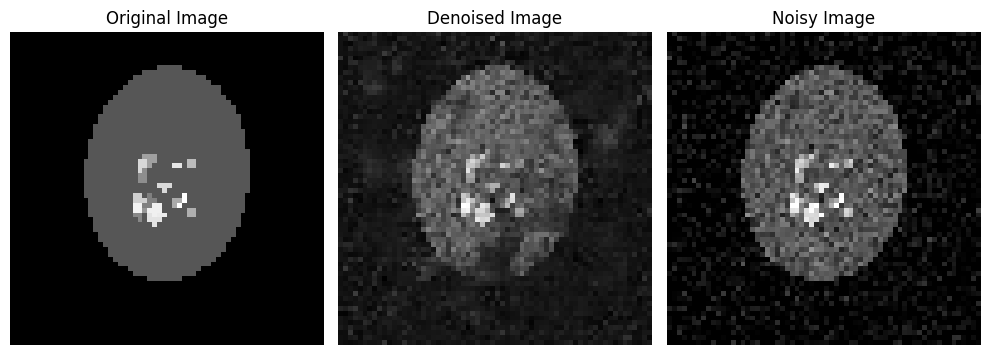

[2023-09-09 08:01:59] Intermediate result: {"iteration": 6000, "loss": 0.00335, "psnr_gt": 22.34838, "var": 0.00529}  (Index 12)
[2023-09-09 08:03:53] Intermediate result: {"iteration": 6500, "loss": 0.00387, "psnr_gt": 21.51554, "var": 0.00465}  (Index 13)
[2023-09-09 08:05:47] Intermediate result: {"iteration": 7000, "loss": 0.00321, "psnr_gt": 22.28455, "var": 0.00389}  (Index 14)
[2023-09-09 08:07:42] Intermediate result: {"iteration": 7500, "loss": 0.00241, "psnr_gt": 22.73825, "var": 0.00322}  (Index 15)


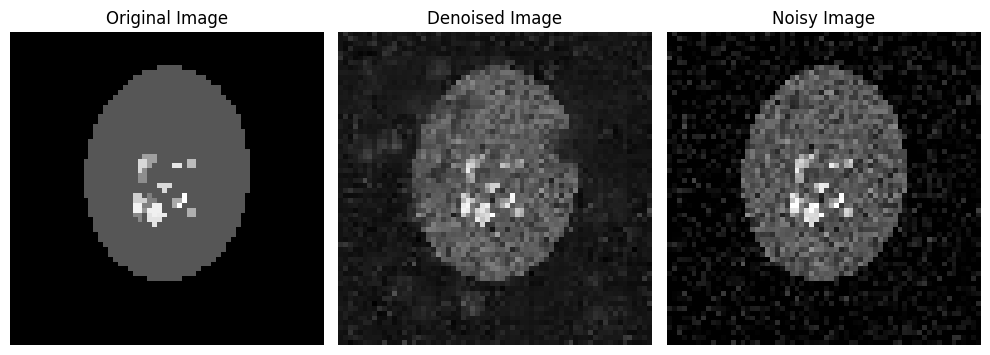

[2023-09-09 08:09:36] Intermediate result: {"iteration": 8000, "loss": 0.00278, "psnr_gt": 22.53527, "var": 0.00274}  (Index 16)
[2023-09-09 08:11:31] Intermediate result: {"iteration": 8500, "loss": 0.0024, "psnr_gt": 22.66754, "var": 0.00244}  (Index 17)
[2023-09-09 08:13:25] Intermediate result: {"iteration": 9000, "loss": 0.0032, "psnr_gt": 21.71725, "var": 0.00225}  (Index 18)
[2023-09-09 08:15:32] Intermediate result: {"iteration": 9500, "loss": 0.00241, "psnr_gt": 22.52882, "var": 0.00212}  (Index 19)


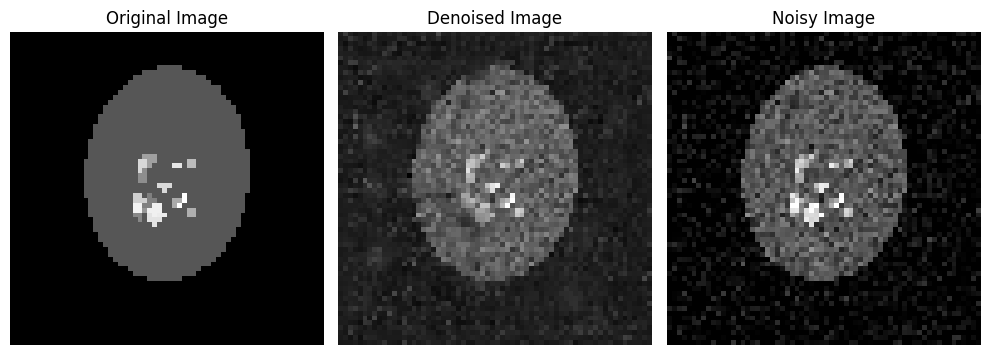

[2023-09-09 08:18:45] Intermediate result: {"iteration": 10000, "loss": 0.00252, "psnr_gt": 22.39975, "var": 0.00202}  (Index 20)
[2023-09-09 08:20:48] Intermediate result: {"iteration": 10500, "loss": 0.00144, "psnr_gt": 23.05337, "var": 0.00195}  (Index 21)
[2023-09-09 08:24:19] Intermediate result: {"iteration": 11000, "loss": 0.00282, "psnr_gt": 22.33137, "var": 0.00189}  (Index 22)


/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [3]:
# INPUTS

# Non HPO inputs
total_iterations = 25000
show_every = 2000 #200
report_every = 500 #25

# HPO inputs
#  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
learning_rate = .001 # 0.1089
buffer_size = 5000# 500
patience = 5000# 100
weight_decay= 5e-7 # 5.0e-8

resolution = 64
noise_level = 0.09
noise_type = 'gaussian'
phantom_num = 45

phantom = np.load(f'phantoms/ground_truth/{resolution}/{phantom_num}.npy')
phantom_noisy= np.load(f'phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{phantom_num}.npy')

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)
model = model = DeepImagePrior(in_channels=1, out_channels=1, depth=5)

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD_ES(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,

                learning_rate=learning_rate, 
                buffer_size=buffer_size,
                patience=patience,
                weight_decay=weight_decay,
                
                report_every=report_every,
                show_every=show_every,
                model=model,
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)


### previous config
# ----------------------------------
# Experiment Configuration:
# 	Total Iterations: 1400
# 	Patience: 200
# 	Buffer Size: 500
# 	Learning Rate: 0.08
# 	Weight Decay: 5e-08
# 	Image Resolution: 64
# 	Plotting every 200 iterations
# ----------------------------------

### new config
# ----------------------------------
# learning_rate = 0.08
# patience = 200
# buffer_size = 500
# weight_decay=5e-8